**Engy-4390** Nuclear Systems Design and Analysis, UMass Lowell, Chem. Eng. Nuclear Program Fall 2024; Prof. V. F. de Almeida

# Constant Thermal Conductivity, Constant Source, and Dirichlet BC

**Student(s):**  Kyle Mills and Billy Manco and Donaita Anglade <br>
**Course:** Engy-4390: Nuclear Systems Design and Analysis  <br>
**Mentor and Collaborator:** Subash Sharma

UMass Lowell, Dept. of Chemical Engineering, Nuclear Energy Program 
<br>
**21 Oct 2024**

---
## Table of Contents<a id="toc"></a>
* [Problem conditions](#whatisit)
* [Setup](#setup)
* [Test One](#test)
---

## [Problem conditions](#toc)<a id='whatisit'></a>

A constant thermal conductivity with a constant source are used with temperature enforced on both ends of the domain. Namely,

 + $k(x) = 87219 \left [ \frac{W}{mK} \right ]$
 + $f(x)= 206151\; \left [ \frac{W}{m^{3}} \right ]$
 + $T(a)= 20$ [°C], and $T(b)= 40$ [°C]

respectively.

## [Setup](#toc)<a id="setup"></a>

In [1]:
'''Generate the target function f'''
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
from scipy.integrate import quad

In [2]:
'''Domain'''
'''Rayleigh Ritz Method with Lagrange FE Basis Functions'''
x_min=0
x_max=0.05

degree = 2  #Degree of the lagrange polinomials used
n_elem = 10 #Number of elements used

In [3]:
'''Domain partition'''
from pyfires import get_domain_partition

In [4]:
'''Parent mapping'''
from pyfires import get_parent_mapping

In [5]:
'''The basis functions'''
from pyfires import get_parent_basis_functions

In [6]:
'''Again the function for the obtaining of the basis functions'''
from pyfires import global_basis_function

In [7]:
'''All global basis functions'''
from pyfires import get_global_basis_functions

In [8]:
'''Pedagogical inner product'''
from pyfires import inner_product

## [Implementing Constrants](#toc)<a id="test"></a>

Test one constraints the system to a constant conductivity and constant source term with a Dirichlet boundary condition. The goal of simulating the domain under these conditions is to produce a graphical solution on how heat is transfered. 

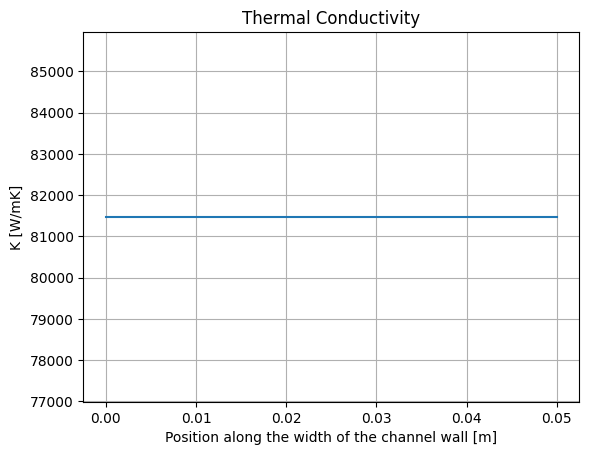

In [9]:
'''Parameters'''
'''Thermal conductivity'''
tc_pts = [(0,81471),(0.05,81471)] #thermal conductivity between the two channels 
therm_cond=np.array(tc_pts) 

k_cond=interp1d(therm_cond[:,0],therm_cond[:,1])

plt.figure()
plt.plot(np.linspace(0,0.05,200),k_cond(np.linspace(0,0.05,200)),label='Target Function')
plt.title('Thermal Conductivity') 
plt.xlabel("Position along the width of the channel wall [m]")
plt.ylabel("K [W/mK]") 
plt.grid()

The thermal conductivity graph is here to demonstrate that the value for thermal conductivty remains constant as you move between points a and b through the brick. 

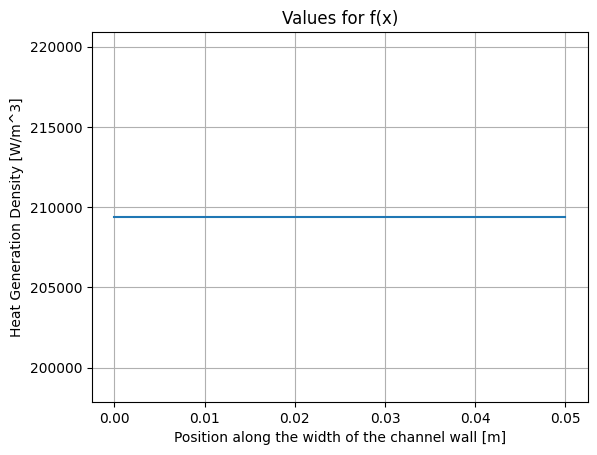

In [10]:
'''Source bias'''
#Use of points to build the source bias function
heat_gen_pts = [(0,209386),(0.05,209386)] #Values of heat generation across the domain 
heat_source=np.array(heat_gen_pts)

func_x=interp1d(heat_source[:,0],heat_source[:,1])

plt.figure()
plt.plot(np.linspace(0,0.05,200),func_x(np.linspace(0,0.05,200)),label='Target Function')
plt.title('Values for f(x)') 
plt.xlabel("Position along the width of the channel wall [m]") 
plt.ylabel("Heat Generation Density [W/m^3]") 
plt.grid()
plt.show()

The heat generation density graph is here to demonstrate that the value for the heat generation denisty remains constant through points a and b in the brick. 

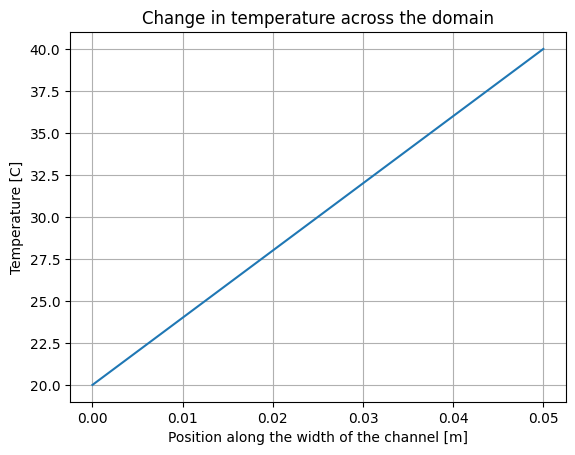

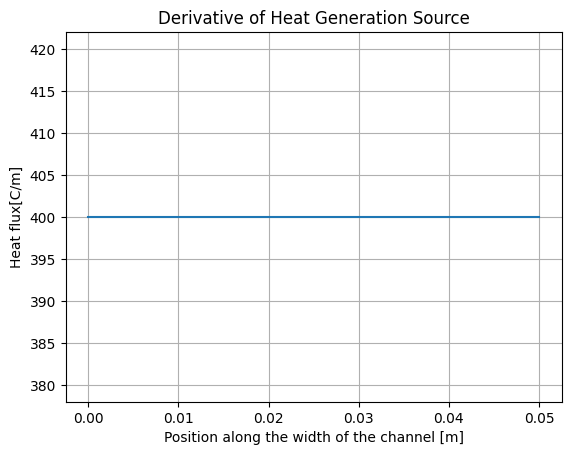

In [11]:
'''Building the slope function'''
u_a=20 #temperature at point a in degrees C
u_b=40 #temperature at point b in degrees C

temp_area = [(0,u_a),(0.05,u_b)] #change in temperature from point a to point b 
temperature=np.array(temp_area)
temp_func=interp1d(temperature[:,0],temperature[:,1])

#Slope of heat generation source 
func_prime=((u_b-u_a)/(x_max-x_min)) 
slope_pts = [(0,func_prime),(0.05,func_prime)]
slope_prime=np.array(slope_pts)
slope_func=interp1d(slope_prime[:,0],slope_prime[:,1])

plt.figure()
plt.plot(np.linspace(0,0.05,200),temp_func(np.linspace(0,0.05,200)))
plt.title("Change in temperature across the domain")
plt.xlabel("Position along the width of the channel [m]") 
plt.ylabel("Temperature [C]") 
plt.grid()
plt.show()

plt.figure()
plt.plot(np.linspace(0,0.05,200),slope_func(np.linspace(0,0.05,200)))
plt.title("Derivative of Heat Generation Source") 
plt.xlabel("Position along the width of the channel [m]")
plt.ylabel("Heat flux[C/m]")
plt.grid()
plt.show()

In [12]:
'''FEM Solution'''
domain_partition = get_domain_partition(degree, n_elem, x_min, x_max)
parent_mapping = get_parent_mapping()
parent_basis_functions = get_parent_basis_functions()

phi_list = get_global_basis_functions(domain_partition, parent_mapping, parent_basis_functions, global_basis_function)[0]
phi_prime_list = get_global_basis_functions(domain_partition, parent_mapping, parent_basis_functions, global_basis_function)[1]

In [13]:
#Building of the A matrix
A_mtrx = np.zeros((len(phi_list), len(phi_list)), dtype=np.float64)
patches = domain_partition[0]
for i in range(len(phi_list)):
    for j in range(len(phi_list)):
        
        phi_i=phi_list[i]
        phi_j=phi_list[j]
        
        phi_prime_i=phi_prime_list[i]
        phi_prime_j=phi_prime_list[j]
        
        h_e=(x_max-x_min)/n_elem
        
        d_x_phi_prime_j = lambda x: k_cond(x) * ((2/h_e)*phi_prime_j(x))
        
        prima = lambda x: phi_prime_i(x)*(2/h_e)
        
        A_mtrx[i,j] = inner_product(prima, d_x_phi_prime_j, patches)

In [14]:
'''Build load vector'''
#The load vector
b_vec = np.zeros(len(phi_list), dtype=np.float64)
patches = domain_partition[0]

for i in range(len(phi_list)):
    phi_i=phi_list[i]
    phi_prime_i=phi_prime_list[i]
    
    b_vec[i] = inner_product(func_x, phi_i, patches)
    
    first_term = lambda x: slope_func(x)*k_cond(x)
    phi_prima_i = lambda x: phi_prime_i(x)*(2/h_e)
    
    b_vec[i] -= inner_product(first_term, phi_prima_i, patches)

#Attempting to fix the error relating to how the integral is solved
#IntegrationWarning: THe occurrence of roundoof error is detected, which prevents the requst tolerance from being achieved. The error may be understimated
# (inner_product_e,_) = quad(integrand, nodes_x[0], nodes_x[-1])

/home/dealmeida/OneDrive/uml-courses/engy-4390/github-repo/projects/2024/fires-brick/tests/pyfires.py:114: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  (inner_product_e, _) = quad(integrand, nodes_x[0], nodes_x[-1])


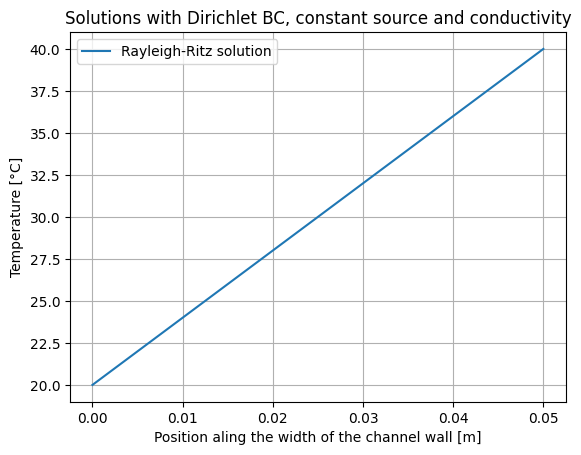

/tmp/ipykernel_7344/91401965.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('The value of the function at the leftmost end of the domain is: %4.2f [°C].'%u_star(x_min))
/tmp/ipykernel_7344/91401965.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('The value of the function at the rightmost end of the domain is: %4.2f [°C].'%u_star(x_max))


The value of the function at the leftmost end of the domain is: 20.00 [°C].
The value of the function at the rightmost end of the domain is: 40.00 [°C].


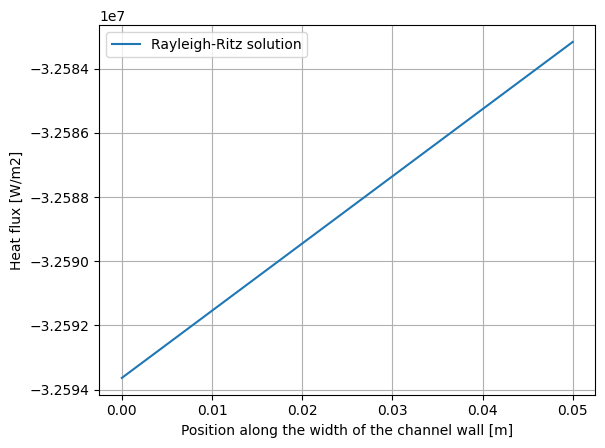

Flux at the boundary:
q_na computed =  [-32593634.64999999]
q_nb computed =  [-32583165.34999998]


In [15]:
'''Solution'''
'''Compute optimal coefficient vector'''
c_star_vec = np.linalg.solve(A_mtrx, b_vec)

'''Plot comparison of f and g_best_vec'''
def u_star(x):
    g_x=temp_func(x)
    for (j,phi_i) in enumerate(phi_list):
        g_x=g_x+(c_star_vec[j])*phi_i(x)
    return g_x

def u_star_prime(x):
    g_x=slope_func(x)
    for j in range(len(phi_list)):
        g_x=g_x+(c_star_vec[j])*((2/h_e)*phi_prime_list[j](x))
    return g_x

plt.figure()
plt.plot(np.linspace(x_min,x_max,2000),u_star(np.linspace(x_min,x_max,2000)),label='Rayleigh-Ritz solution')
plt.title('Solutions with Dirichlet BC, constant source and conductivity')
plt.xlabel("Position aling the width of the channel wall [m]")
plt.ylabel("Temperature [°C]")
plt.legend()
plt.grid()
plt.show()

#Temperuature values at the beginning and end of the domain
print('The value of the function at the leftmost end of the domain is: %4.2f [°C].'%u_star(x_min))
print('The value of the function at the rightmost end of the domain is: %4.2f [°C].'%u_star(x_max))

#Plotting the flux
plt.figure()
plt.plot(np.linspace(x_min,x_max,2000),-k_cond(np.linspace(x_min,x_max,2000))*u_star_prime((np.linspace(x_min,x_max,2000))),label='Rayleigh-Ritz solution')
plt.xlabel("Position along the width of the channel wall [m]")
plt.ylabel("Heat flux [W/m2]")
plt.legend()
plt.grid()
plt.show()

print("Flux at the boundary:") 
print('q_na computed = ', -k_cond(x_min)*u_star_prime(x_min))
print('q_nb computed = ', -k_cond(x_max)*u_star_prime(x_max))